# Simulate Trading Bot Action

<div style="display: flex;">
    <div style="flex: 1; display: flex; align-items: center;">
        <img src="src/A.png" style="width: 100%;">
    </div>
    <div style="flex: 1; display: flex; align-items: center;">
        <img src="src/B.png" style="width: 100%;">
    </div>
</div>

## Download Historical Data

### Download 100 prior days from today

In [12]:
from datetime import datetime, timedelta

N_DAYS = 100

date_end = datetime.today().date()
date_start = date_end - timedelta(days=N_DAYS)
date_start = str(date_start)
date_start

'2024-02-28'

### Import Library

In [13]:
import sys
sys.path.append('../../../modules/')

In [14]:
import utils

### Download Data

In [15]:
symbol = 'BTC/USD'
data = utils.get_data_crypto_daily(symbol=symbol, start=date_start)
data

{'bars': {'BTC/USD': [{'c': 62521.45,
    'h': 64114.375314861,
    'l': 51116.625310173,
    'n': 736,
    'o': 57116.6395,
    't': '2024-02-28T06:00:00Z',
    'v': 11.07236602,
    'vw': 59869.4034778129},
   {'c': 61335.7055,
    'h': 63654.5755,
    'l': 60390.816,
    'n': 510,
    'o': 62504.9235,
    't': '2024-02-29T06:00:00Z',
    'v': 6.677049422,
    'vw': 62004.0155700017},
   {'c': 62079.7935,
    'h': 63110.2535,
    'l': 61219.93,
    'n': 221,
    'o': 61295.611,
    't': '2024-03-01T06:00:00Z',
    'v': 6.626800627,
    'vw': 61998.4901195568},
   {'c': 61943.201,
    'h': 62344.33,
    'l': 61682.798,
    'n': 131,
    'o': 62076.62,
    't': '2024-03-02T06:00:00Z',
    'v': 0.840388591,
    'vw': 62031.3562011778},
   {'c': 63395.746,
    'h': 64265.162,
    'l': 61453.42,
    'n': 100,
    'o': 61934.7,
    't': '2024-03-03T06:00:00Z',
    'v': 1.675955527,
    'vw': 62617.1338362145},
   {'c': 67002.88,
    'h': 68828.19,
    'l': 63027.295285359,
    'n': 689,
  

### Process the DataFrame

In [17]:
df = utils.process_df(data=data, symbol=symbol)
df

,Open,High,Low,Close,Volume
Date,,,,,
2024-02-28 06:00:00+00:00,57116.6395,64114.375315,51116.62531,62521.4500,11.072366
2024-02-29 06:00:00+00:00,62504.9235,63654.575500,60390.81600,61335.7055,6.677049
...,...,...,...,...,...
2024-06-06 05:00:00+00:00,71059.9955,71622.498000,70125.82000,71202.7300,1.823753
2024-06-07 05:00:00+00:00,71268.8700,71924.646000,68775.31000,69225.5500,0.938894


## Bollinger Strategy

### Calculate Bands

In [18]:
df_bollinger = df[['Close']].copy()

k = 2
n_windows = 30

rolling_std = df_bollinger.Close.rolling(n_windows).std()
rolling_mean = df_bollinger.Close.rolling(n_windows).mean()

df_bollinger = (df_bollinger
 .assign(
     upper = rolling_mean + rolling_std * k,
     lower = rolling_mean - rolling_std * k)
)

df_bollinger

,Close,upper,lower
Date,,,
2024-02-28 06:00:00+00:00,62521.4500,NaN,NaN
2024-02-29 06:00:00+00:00,61335.7055,NaN,NaN
...,...,...,...
2024-06-06 05:00:00+00:00,71202.7300,73501.029016,60359.970351
2024-06-07 05:00:00+00:00,69225.5500,73476.726644,60899.800389


### Visualize Data

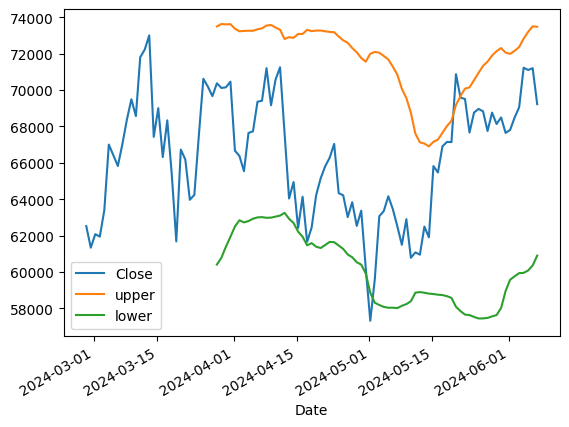

In [19]:
df_bollinger.plot();

## Prepare Alpaca Trading API

In [ ]:
import os

API_KEY = os.getenv('API_KEY')
API_SECRET = os.getenv('API_SECRET')

In [ ]:
from alpaca.trading.client import TradingClient

client = TradingClient(API_KEY, API_SECRET, paper=True)

## Configure market order request

In [30]:
from alpaca.trading.requests import MarketOrderRequest
from alpaca.trading.enums import OrderSide, TimeInForce

symbol = 'BTCUSD'

request_order = MarketOrderRequest(
    symbol=symbol,
    qty=0.1,
    side=OrderSide.BUY,
    time_in_force=TimeInForce.GTC)

request_order

{   'client_order_id': None,
    'extended_hours': None,
    'notional': None,
    'order_class': None,
    'position_intent': None,
    'qty': 0.1,
    'side': <OrderSide.BUY: 'buy'>,
    'stop_loss': None,
    'symbol': 'BTCUSD',
    'take_profit': None,
    'time_in_force': <TimeInForce.GTC: 'gtc'>,
    'type': <OrderType.MARKET: 'market'>}

```python
# Order to Buy and Open Position
request = client_trading.submit_order(order_data=request_order)

# Close position
request = client_trading.close_position(symbol)
```

## Signals to buy, sell or pass

### Get last price

In [31]:
last_day = df_bollinger.iloc[-1]
last_day

Close    69225.550000
upper    73476.726644
lower    60899.800389
Name: 2024-06-07 05:00:00+00:00, dtype: float64

In [32]:
close, upper, lower = last_day

### Open position?

In [36]:
try:
    client.get_open_position(symbol)
    flag_bought = True
except Exception as e:
    flag_bought = False
    print(e)

### Conditionals

In [37]:
if (lower > close) and  (not flag_bought):
    request = client.submit_order(order_data=request_order)
elif (close > upper) and (flag_bought):
    request = client.close_position(symbol)
else:
    request = 'No trade executed.'
    
request

'No trade executed.'